# Baseline: House Price Prediction

Этот ноутбук строит минимальный рабочий бейзлайн для задачи предсказания цены дома (Kaggle House Prices).

Шаги:
- Загрузка данных
- Препроцессинг (импутация, One-Hot Encoding)
- Бейзлайн-модель (RandomForestRegressor)
- K-Fold CV (RMSE)
- Hold-out оценка
- Сохранение модели


In [1]:
# Imports and setup
import os
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

PROJECT_ROOT = os.path.abspath(os.path.join(os.path.dirname(".."), ".."))
DATA_DIR = os.path.join(PROJECT_ROOT, "data", "raw")
TRAIN_PATH = os.path.join(DATA_DIR, "train.csv")
MODELS_DIR = os.path.join(PROJECT_ROOT, "models")
os.makedirs(MODELS_DIR, exist_ok=True)

TRAIN_PATH


'C:\\Users\\User\\PycharmProjects\\Houses\\data\\raw\\train.csv'

In [2]:
# Load data
import pathlib
from IPython.display import display

if not os.path.exists(TRAIN_PATH):
    raise FileNotFoundError(f"Place train.csv into {DATA_DIR}")

df = pd.read_csv(TRAIN_PATH)
display(df.head())
print(df.shape)
assert "SalePrice" in df.columns, "train.csv must contain SalePrice column"


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


(1460, 81)


[ШАГ 3] Построение графиков визуализации...


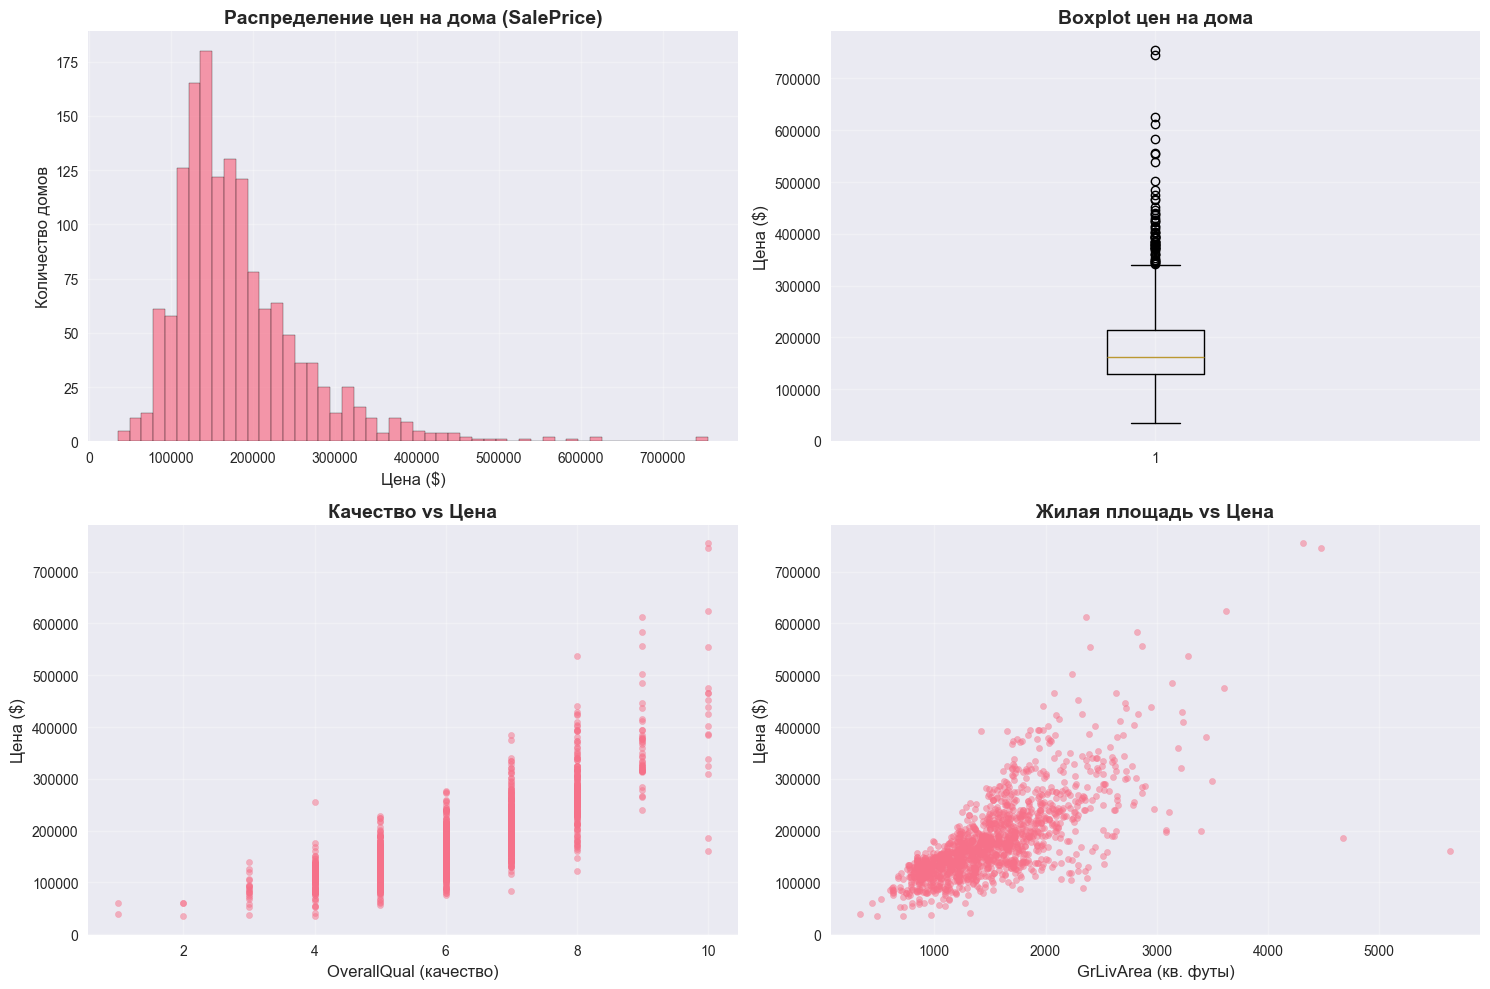

СТАТИСТИКА ПО ЦЕНАМ (SalePrice):
Средняя цена: $180,921.20
Медианная цена: $163,000.00
Минимальная цена: $34,900.00
Максимальная цена: $755,000.00
Стандартное отклонение: $79,442.50


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

print("[ШАГ 3] Построение графиков визуализации...")

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].hist(df['SalePrice'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Распределение цен на дома (SalePrice)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Цена ($)', fontsize=12)
axes[0, 0].set_ylabel('Количество домов', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].boxplot(df['SalePrice'])
axes[0, 1].set_title('Boxplot цен на дома', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Цена ($)', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)

if 'OverallQual' in df.columns:
    axes[1, 0].scatter(df['OverallQual'], df['SalePrice'], alpha=0.5, s=20)
    axes[1, 0].set_title('Качество vs Цена', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('OverallQual (качество)', fontsize=12)
    axes[1, 0].set_ylabel('Цена ($)', fontsize=12)
    axes[1, 0].grid(True, alpha=0.3)

if 'GrLivArea' in df.columns:
    axes[1, 1].scatter(df['GrLivArea'], df['SalePrice'], alpha=0.5, s=20)
    axes[1, 1].set_title('Жилая площадь vs Цена', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('GrLivArea (кв. футы)', fontsize=12)
    axes[1, 1].set_ylabel('Цена ($)', fontsize=12)
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=" * 50)
print("СТАТИСТИКА ПО ЦЕНАМ (SalePrice):")
print("=" * 50)
print(f"Средняя цена: ${df['SalePrice'].mean():,.2f}")
print(f"Медианная цена: ${df['SalePrice'].median():,.2f}")
print(f"Минимальная цена: ${df['SalePrice'].min():,.2f}")
print(f"Максимальная цена: ${df['SalePrice'].max():,.2f}")
print(f"Стандартное отклонение: ${df['SalePrice'].std():,.2f}")
print("=" * 50)


In [4]:
# Split target and features
y = df["SalePrice"]
X = df.drop(columns=["SalePrice"]) 

num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

len(num_cols), len(cat_cols), list(cat_cols)[:5]


(37, 43, ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour'])

In [5]:
# Preprocessing and model
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ]
)

model = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)

pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", model)
])

pipe


,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [6]:
# Cross-validation (RMSE)
import numpy as np
scores = cross_val_score(pipe, X, y, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
rmse_mean, rmse_std = (-scores).mean(), (-scores).std()
rmse_mean, rmse_std


(np.float64(29903.008383606608), np.float64(3857.926327639523))

In [ ]:
# Hold-out validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
pipe.fit(X_train, y_train)
valid_pred = pipe.predict(X_valid)
holdout_rmse = mean_squared_error(y_valid, valid_pred, squared=False)
holdout_rmse


In [12]:
# Save model pipeline
model_path = os.path.join(MODELS_DIR, "baseline_random_forest.pkl")
joblib.dump(pipe, model_path)
model_path


'C:\\Users\\User\\PycharmProjects\\Houses\\models\\baseline_random_forest.pkl'

In [ ]:
import joblib
pipe = joblib.load("../models/baseline_random_forest.pkl")
pipe


In [9]:
# Predict house prices for Kaggle test set
TEST_PATH = os.path.join(DATA_DIR, "test.csv")
if not os.path.exists(TEST_PATH):
    raise FileNotFoundError(f"Place test.csv into {DATA_DIR}")

test_df = pd.read_csv(TEST_PATH)
# подключаем обученный пайплайн (из памяти или из файла, если перезапускали ноутбук)
if 'pipe' not in globals():
    pipe = joblib.load(os.path.join(MODELS_DIR, "baseline_random_forest.pkl"))

test_predictions = pipe.predict(test_df)

test_df.assign(SalePrice=test_predictions).loc[:, ["Id", "SalePrice"]].head()


,Id,SalePrice
0,1461,129234.750000
1,1462,151719.083333
2,1463,178876.833333
3,1464,186358.713333
4,1465,204149.543333
